In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,sklearn,tf,keras:
    print(module.__name__,module.__version__)

Using TensorFlow backend.


2.1.0
sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)
matplotlib 3.1.3
numpy 1.18.1
sklearn 0.22.1
tensorflow 2.1.0
keras 2.3.1


In [3]:
train_dir = os.path.join("plantseeding/train" )
test_dir = os.path.join("plantseeding/test" )
label_file = os.path.join("plantseeding/sample_submission.csv" )
print(os.path.exists(train_dir))
print(os.path.exists(test_dir))
print(os.path.exists(label_file))

True
True
True


In [4]:
height = 128
width = 128
channels = 3
batch_size = 64
num_classes = 12

trian_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                        rotation_range = 40,
                                                        width_shift_range = 0.2,
                                                        height_shift_range = 0.2,
                                                        shear_range = 0.2,
                                                        zoom_range = 0.2,
                                                        horizontal_flip = True,
                                                        fill_mode = 'nearest')
train_generator = trian_datagen.flow_from_directory(train_dir,
                                                  target_size = (height,width),
                                                  batch_size = batch_size,
                                                  seed = 7,
                                                  shuffle = True,
                                                  class_mode = "categorical")
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(train_dir,
                                                  target_size = (height,width),
                                                  batch_size = batch_size,
                                                  seed = 7,
                                                  shuffle = False,
                                                  class_mode = "categorical")
train_num = train_generator.samples
test_num = test_generator.samples
print(train_num,test_num)

Found 4750 images belonging to 12 classes.
Found 4750 images belonging to 12 classes.
4750 4750


In [6]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters = 32,kernel_size = 3,padding = 'same',
                       activation = 'relu',input_shape = [width,height,channels]),
    keras.layers.Conv2D(filters = 32,kernel_size = 3,padding = 'same',
                       activation = 'relu'),
    keras.layers.MaxPool2D(pool_size = 2),
    
    keras.layers.Conv2D(filters = 64,kernel_size = 3,padding = 'same',
                       activation = 'relu'),
    keras.layers.Conv2D(filters = 64,kernel_size = 3,padding = 'same',
                       activation = 'relu'),
    keras.layers.MaxPool2D(pool_size = 2),
    
    keras.layers.Conv2D(filters = 128,kernel_size = 3,padding = 'same',
                       activation = 'relu'),
    keras.layers.Conv2D(filters = 128,kernel_size = 3,padding = 'same',
                       activation = 'relu'),
    keras.layers.MaxPool2D(pool_size = 2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128,activation = 'selu'),
    keras.layers.Dense(num_classes,activation = 'softmax'),
])
model.compile(loss = "categorical_crossentropy",
             optimizer = "adam",
             metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)      

In [7]:
epochs = 50
logdir = os.path.join("50epchos_result" )
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 "model.h5")
callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                   save_best_only = True)
]
history = model.fit_generator(train_generator,
                             steps_per_epoch = train_num//batch_size,
                             epochs = epochs,
                              validation_data = test_generator,
                              validation_steps = test_num//batch_size，
                              callbacks = callbacks
                             )

Epoch 1/50
74/74 [==============================] - 365s 5s/step - loss: 2.4882 - accuracy: 0.1302 - val_loss: 2.5810 - val_accuracy: 0.1381
Epoch 2/50
74/74 [==============================] - 259s 3s/step - loss: 2.4200 - accuracy: 0.1285 - val_loss: 2.5003 - val_accuracy: 0.1564
Epoch 3/50
74/74 [==============================] - 290s 4s/step - loss: 2.3738 - accuracy: 0.1656 - val_loss: 3.2498 - val_accuracy: 0.2900
Epoch 4/50
74/74 [==============================] - 277s 4s/step - loss: 1.7977 - accuracy: 0.3762 - val_loss: 1.2369 - val_accuracy: 0.5166
Epoch 5/50
74/74 [==============================] - 254s 3s/step - loss: 1.5986 - accuracy: 0.4464 - val_loss: 1.1039 - val_accuracy: 0.5668
Epoch 6/50
74/74 [==============================] - 248s 3s/step - loss: 1.4092 - accuracy: 0.5143 - val_loss: 1.3329 - val_accuracy: 0.6204
Epoch 7/50
74/74 [==============================] - 262s 4s/step - loss: 1.2822 - accuracy: 0.5523 - val_loss: 0.5150 - val_accuracy: 0.6274
Epoch 8/50
74

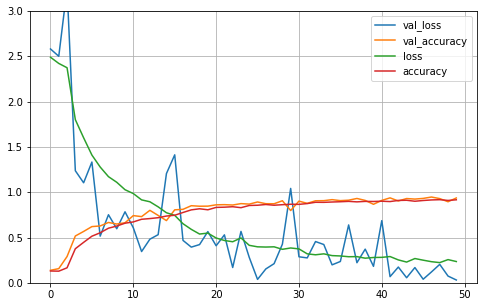

In [8]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,3)
    plt.show()
    
plot_learning_curves(history)